[View in Colaboratory](https://colab.research.google.com/github/jmg007007/Thesis_AIS/blob/master/Keras_LSTM_Multivariate_Time_Series_Forecast.ipynb)

Website that I took the baseline code from:

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Imports

In [0]:
#Run Cell to upload local files
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import random
import os
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


dataset = pd.read_csv('503000370_clip_NSIDC_EASE_Min_Max.csv', usecols = ['UNX','EASE_LAT','EASE_LON','COG_DEG','SPEED_KNOT'])

dataset.head()

Using TensorFlow backend.


,UNX,EASE_LAT,EASE_LON,COG_DEG,SPEED_KNOT
0,0.000000,0.435395,0.228707,0.852368,0.0
1,0.000105,0.435378,0.228690,0.532033,0.0
2,0.000109,0.435386,0.228690,0.532033,0.0
3,0.000133,0.435355,0.228707,0.779944,0.0
4,0.000138,0.435360,0.228707,0.779944,0.0


# Reframe 

In [0]:
# specify the number of lag hours
n_posit = 1
n_features = 5

In [3]:
# frame as supervised learning
reframed = series_to_supervised(dataset, n_posit)
reframed.shape

(122094, 10)

In [4]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.000000,0.435395,0.228707,0.852368,0.0,0.000105,0.435378,0.228690,0.532033,0.0
2,0.000105,0.435378,0.228690,0.532033,0.0,0.000109,0.435386,0.228690,0.532033,0.0
3,0.000109,0.435386,0.228690,0.532033,0.0,0.000133,0.435355,0.228707,0.779944,0.0
4,0.000133,0.435355,0.228707,0.779944,0.0,0.000138,0.435360,0.228707,0.779944,0.0
5,0.000138,0.435360,0.228707,0.779944,0.0,0.000152,0.435347,0.228715,0.952646,0.0


In [6]:
#ensure all data is float
reframed = reframed.astype('float32')
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122094 entries, 1 to 122094
Data columns (total 10 columns):
var1(t-1)    122094 non-null float32
var2(t-1)    122094 non-null float32
var3(t-1)    122094 non-null float32
var4(t-1)    122094 non-null float32
var5(t-1)    122094 non-null float32
var1(t)      122094 non-null float32
var2(t)      122094 non-null float32
var3(t)      122094 non-null float32
var4(t)      122094 non-null float32
var5(t)      122094 non-null float32
dtypes: float32(10)
memory usage: 5.6 MB


In [7]:
# Drop columns we don't want to predict
reframed.drop(columns=['var1(t)', 'var4(t)', 'var5(t)'], axis=1).head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var2(t),var3(t)
1,0.000000,0.435395,0.228707,0.852368,0.0,0.435378,0.228690
2,0.000105,0.435378,0.228690,0.532033,0.0,0.435386,0.228690
3,0.000109,0.435386,0.228690,0.532033,0.0,0.435355,0.228707
4,0.000133,0.435355,0.228707,0.779944,0.0,0.435360,0.228707
5,0.000138,0.435360,0.228707,0.779944,0.0,0.435347,0.228715


In [8]:
# Min_Max Scaler (no change to data but needed for evaluation below)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)
print(scaled)

[[0.00000000e+00 4.35394645e-01 2.28707045e-01 ... 2.28690162e-01
  5.32033443e-01 0.00000000e+00]
 [1.04571682e-04 4.35377538e-01 2.28690162e-01 ... 2.28690162e-01
  5.32033443e-01 0.00000000e+00]
 [1.09324942e-04 4.35385525e-01 2.28690162e-01 ... 2.28707045e-01
  7.79944301e-01 0.00000000e+00]
 ...
 [9.99985754e-01 5.24319187e-02 5.40896654e-02 ... 5.40896654e-02
  5.73816180e-01 8.54700897e-03]
 [9.99995291e-01 5.24455421e-02 5.40896654e-02 ... 5.40727712e-02
  4.06685233e-01 8.54700897e-03]
 [1.00000000e+00 5.24228364e-02 5.40727712e-02 ... 5.41065559e-02
  8.69080782e-01 8.54700897e-03]]


# Split and Reshape

In [0]:
# split into train and test sets
n_train_hours = 109886
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [10]:
# split into input and outputs
n_obs = n_posit * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(109886, 5) 109886 (109886,)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_posit, n_features))
test_X = test_X.reshape((test_X.shape[0], n_posit, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(109886, 1, 5) (109886,) (12208, 1, 5) (12208,)


# Design and Run the Network

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 109886 samples, validate on 12208 samples
Epoch 1/50
 - 4s - loss: 0.0057 - val_loss: 0.0364
Epoch 2/50
 - 4s - loss: 0.0104 - val_loss: 0.0325
Epoch 3/50
 - 4s - loss: 0.0077 - val_loss: 0.0211
Epoch 4/50
 - 4s - loss: 0.0068 - val_loss: 0.0187
Epoch 5/50
 - 4s - loss: 0.0053 - val_loss: 0.0192
Epoch 6/50
 - 4s - loss: 0.0040 - val_loss: 0.0099
Epoch 7/50
 - 4s - loss: 0.0033 - val_loss: 0.0107
Epoch 8/50
 - 4s - loss: 0.0028 - val_loss: 0.0081
Epoch 9/50
 - 4s - loss: 0.0028 - val_loss: 0.0084
Epoch 10/50
 - 4s - loss: 0.0023 - val_loss: 0.0063
Epoch 11/50
 - 4s - loss: 0.0024 - val_loss: 0.0081
Epoch 12/50
 - 4s - loss: 0.0021 - val_loss: 0.0062
Epoch 13/50
 - 4s - loss: 0.0022 - val_loss: 0.0034
Epoch 14/50
 - 4s - loss: 0.0020 - val_loss: 0.0033
Epoch 15/50
 - 4s - loss: 0.0019 - val_loss: 0.0038
Epoch 16/50
 - 4s - loss: 0.0017 - val_loss: 0.0021
Epoch 17/50
 - 4s - loss: 0.0019 - val_loss: 0.0035
Epoch 18/50
 - 4s - loss: 0.0016 - val_loss: 0.0083
Epoch 19/50
 - 4s - lo

 - 4s - loss: 0.0014 - val_loss: 0.0032
Epoch 44/50
 - 4s - loss: 0.0014 - val_loss: 0.0065
Epoch 45/50
 - 4s - loss: 0.0013 - val_loss: 0.0033
Epoch 46/50
 - 4s - loss: 0.0015 - val_loss: 0.0032
Epoch 47/50
 - 4s - loss: 0.0015 - val_loss: 0.0065
Epoch 48/50
 - 4s - loss: 0.0014 - val_loss: 0.0077
Epoch 49/50
 - 4s - loss: 0.0015 - val_loss: 0.0066
Epoch 50/50
 - 4s - loss: 0.0014 - val_loss: 0.0085


# Evaluate Network

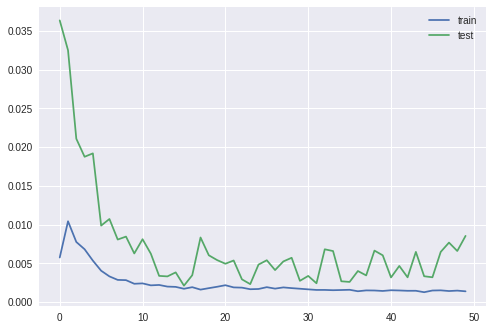

In [14]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_posit*n_features))

In [16]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: ignored

In [18]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: ignored

In [0]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)